In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
import time
%matplotlib inline

2023-02-17 14:00:13.649406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ', len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [3]:
mobile = tf.keras.applications.mobilenet.MobileNet()

2023-02-17 14:01:23.574099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 14:01:30.275084: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2627 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [4]:
def prepare_image(file):
    img_path = 'data/MobileNet-samples/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [5]:
from IPython.display import Image
Image(filename='data/MobileNet-samples/1.PNG', width=300, height=200)

FileNotFoundError: [Errno 2] No such file or directory: 'data/MobileNet-samples/1.PNG'

In [ ]:
preprocessed_image = prepare_image('1.PNG')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

In [ ]:
assert results[0][0][1] == 'American_chameleon'

In [ ]:
Image(filename='data/MobileNet-samples/2.PNG', width=300, height=200)

In [ ]:
preprocessed_image = prepare_image('2.PNG')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils_decode_predictions(predictions)
results

In [ ]:
assert results[0][0][1] == 'espresso'

In [ ]:
Image(filename='data/MobileNet-samples/3.PNG', width=300, height=200)

In [ ]:
preprocessed_image = prepare_image('3.PNG')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils_decode_predictions(predictions)
results

In [ ]:
assert results[0][0][1] == 'strawberry'

## Sign Language Dataset
Github repo: https://github.com/srmq/Sign-Language-Digits-Dataset

* 10 classes (digits 0--9)
* Class data:
  * class 0: 205 images
  * class 1: 206 images
  * class 2: 206 images
  * class 3: 206 images
  * class 4: 207 images
  * class 5: 207 images
  * class 6: 207 images
  * class 7: 206 images
  * class 8: 208 images
  * class 9: 204 images

In [34]:
# Organize data into train, valid, test dirs
os.chdir('data/Sign-Language-Digits-Dataset')
if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    
    for i in range(0, 10):
        shutil.move(f"{i}", 'train')
        os.mkdir(f"valid/{i}")
        os.mkdir(f"test/{i}")
        
        valid_samples = set(random.sample(os.listdir(f"train/{i}"), 30))
        for j in valid_samples:
            shutil.move(f"train/{i}/{j}", f"valid/{i}")
        
        test_samples = random.sample(os.listdir(f"train/{i}"), 5)
        for k in test_samples:
            shutil.move(f"train/{i}/{k}", f"test/{i}")
        os.sync()
os.chdir('../..')

In [6]:
for i in range(0, 10):
    assert len(os.listdir(f"data/Sign-Language-Digits-Dataset/valid/{i}")) == 30
    assert len(os.listdir(f"data/Sign-Language-Digits-Dataset/test/{i}")) == 5

In [9]:
train_path = 'data/Sign-Language-Digits-Dataset/train'
valid_path = 'data/Sign-Language-Digits-Dataset/valid'
test_path = 'data/Sign-Language-Digits-Dataset/test'

In [10]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [11]:
assert train_batches.n == 1712
assert valid_batches.n == 300
assert test_batches.n == 50
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 10

## Modify Model

In [51]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [52]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [53]:
def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
    return {'non_trainable_params': non_trainable_params, 'trainable_params': trainable_params}

In [54]:
params = count_params(mobile)

In [55]:
assert params['non_trainable_params'] == 21888
assert params['trainable_params'] == 4231976

In [56]:
x = mobile.layers[-6].output  
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = Dense(units=10, activation='softmax')(x)

In [57]:
model = Model(inputs=mobile.input, outputs=output)

In [58]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [59]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [60]:
params = count_params(model)
assert params['non_trainable_params'] == 1365184
assert params['trainable_params'] == 1873930

## Train the model

In [61]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [62]:
# Run for more epochs (~30) to see better results
model.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=2)

Epoch 1/30


2023-02-17 14:42:57.499468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-17 14:43:09.755086: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2023-02-17 14:43:09.914516: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-17 14:43:09.914555: W tensorflo

172/172 - 76s - loss: 0.6419 - accuracy: 0.8160 - val_loss: 0.3710 - val_accuracy: 0.8733 - 76s/epoch - 441ms/step
Epoch 2/30
172/172 - 6s - loss: 0.1130 - accuracy: 0.9825 - val_loss: 0.1762 - val_accuracy: 0.9667 - 6s/epoch - 33ms/step
Epoch 3/30
172/172 - 6s - loss: 0.0632 - accuracy: 0.9918 - val_loss: 0.1195 - val_accuracy: 0.9800 - 6s/epoch - 33ms/step
Epoch 4/30
172/172 - 6s - loss: 0.0260 - accuracy: 1.0000 - val_loss: 0.0996 - val_accuracy: 0.9767 - 6s/epoch - 34ms/step
Epoch 5/30
172/172 - 6s - loss: 0.0270 - accuracy: 0.9971 - val_loss: 0.0925 - val_accuracy: 0.9900 - 6s/epoch - 33ms/step
Epoch 6/30
172/172 - 6s - loss: 0.0170 - accuracy: 0.9994 - val_loss: 0.0784 - val_accuracy: 0.9900 - 6s/epoch - 33ms/step
Epoch 7/30
172/172 - 6s - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.0811 - val_accuracy: 0.9900 - 6s/epoch - 33ms/step
Epoch 8/30
172/172 - 6s - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.0882 - val_accuracy: 0.9900 - 6s/epoch - 34ms/step
Epoch 9/30
172/172 - 6s 

## Predict sign language digits

In [63]:
test_labels = test_batches.classes

In [64]:
predictions = model.predict(x=test_batches, verbose=0)

In [65]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [66]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [68]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title='Confusion matrix',
    cmap=plt.cm.Blues
    ):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j, i, cm[i, j],
        horizontalalignment='center',
        color='white' if cm[i, j] > thresh else 'black'
        )
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


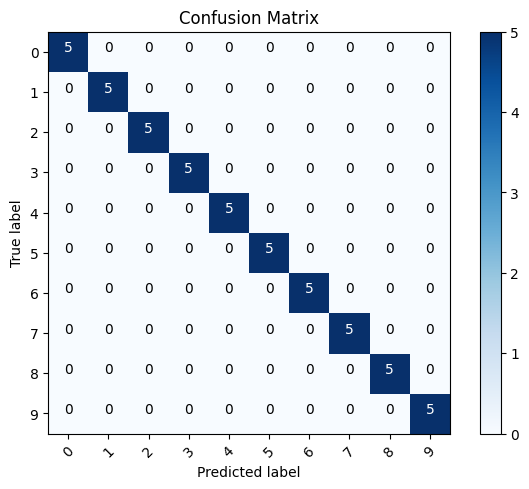

In [69]:
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')